# Capstone 2.3: Predicted Circular Dichroism Spectra from Primary Amino Acid Sequence

## Exploratory Data Analysis (EDA)

Data is coming from the Protein Circular Dichroism Data Bank (https://pcddb.cryst.bbk.ac.uk/).
Citation information: The PCDDB (protein circular dichroism data bank): A bioinformatics resource for protein characterisations and methods development. Ramalli SG, Miles AJ, Janes RW, Wallace BA., J Mol Biol (2022) 

In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import traceback
from aaindex import aaindex1
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

In [2]:
# Unpickle data
# dfOG = pd.read_pickle('pcd_df.pkl')
dfOG = pd.read_pickle("C:/Users/dkoul/OneDrive/Documents/Springboard/Capstone 2/pcd_df.pkl")

## Data Structure Reminder

The dataframe contains the PCDDB IDs as the index values, with three corresponding columns for each.

In [3]:
dfOG.head()

,Info,CD,Calibration
CD0000001000,"{'PCDDBID': 'CD0000001000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed...,Wavelength Calibration Spectrum 0 ...
CD0000002000,"{'PCDDBID': 'CD0000002000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed ...,Wavelength Calibration Spectrum 0 ...
CD0000003000,"{'PCDDBID': 'CD0000003000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed Av...,Wavelength Calibration Spectrum 0 ...
CD0000004000,"{'PCDDBID': 'CD0000004000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed Av...,Wavelength Calibration Spectrum 0 ...
CD0000005000,"{'PCDDBID': 'CD0000005000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed...,Wavelength Calibration Spectrum 0 ...


In [4]:
print(type(dfOG['Info']))
print(type(dfOG['Info'][0]))
print(dfOG['Info'][0].keys())

<class 'pandas.core.series.Series'>
<class 'dict'>
dict_keys(['PCDDBID', 'FILE EXTRACTED', 'Protein Name', 'Alternative Protein Names', 'Source Organism', 'Protein Supplier', 'Expression System or natural source', 'Expressed As', 'Mutation Details', 'Expression tags (if any)', 'Ligands Present and Concentration or ratio', 'Macromolecular Partner(s) and Concentration or ratio', 'Deposition Date', 'Dichroism Units of Raw Sample Data', 'Dichroism Units of Raw Baseline Data', 'Dichroism Units of Average Sample Data', 'Dichroism Units of Averaged Baseline Data', 'Dichroism Units of Net Smoothed Data', 'Dichroism Units of Processed Data', 'CD or SRCD', 'Protein Concentration (mg/ml)', 'Concentration Quantification Method', 'Protein Purity (%)', 'Purity Quantification Method', 'Buffer Contents and Concentrations', 'Baseline Contents', 'Experimental Temperature (C)', 'Instrument or beamline', 'Detector Angle (Scattering Angle)', 'Sample Cell Pathlength (cm)', 'Cell Pathlength Calibration Metho

C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\1884154440.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['Info'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\1884154440.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['Info'][0].keys())


Info column is a pandas series of dictionaries of the metadata for each entry with the keys indicated above.

In [5]:
print(type(dfOG['CD']))
print(type(dfOG['CD'][0]))
print(dfOG['CD'][0].head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
   Wavelength     Final        HT  Smoothed  Avg. Sample  Avg.Baseline
0       300.0 -0.018660  237727.0  -129.733     465689.0      465406.0
1       299.0 -0.109954  237082.0  -765.400     465460.0      465812.0
2       298.0 -0.004505  236498.0   -31.400     465667.0      465285.0
3       297.0  0.044540  235893.0   310.822     466046.0      465040.0
4       296.0  0.059347  235366.0   414.663     465563.0      464877.0


C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\1836454426.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['CD'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\1836454426.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['CD'][0].head())


In [6]:
print(type(dfOG['Calibration']))
print(type(dfOG['Calibration'][0]))
print(dfOG['Calibration'][0].head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
  Wavelength  Calibration Spectrum
0      350.0                -602.0
1      349.0                 384.0
2      348.0                -954.0
3      347.0                 641.0
4      346.0                 146.0


C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\3641678982.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['Calibration'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\3641678982.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['Calibration'][0].head())


## Pertinent columns

To develop the algorithm, we will need to identify with of the CD columns to use as our spectrum. We want our algorithm to predict one of the columns vs. the Wavelength. For the input, we will need to access the amino acid sequence. This can be found in the Info dictionary for each entry using the key 'Sequence'. <br>
Other values that are likely to be relevant are the units; of potential utility if data needs to be subsetted further or to enrich predictions might be buffer/temperature/other experimental conditions and potential quality metrics (e.g. 'CD signal at 290nm (mdeg)').

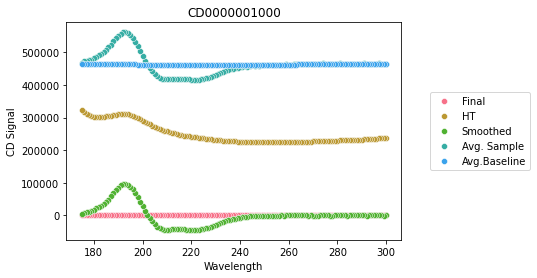

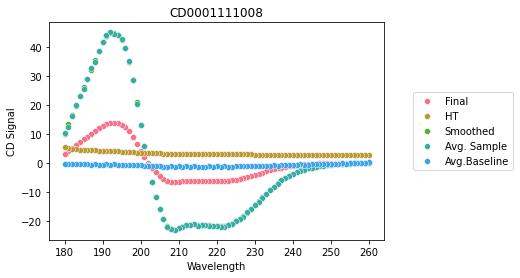

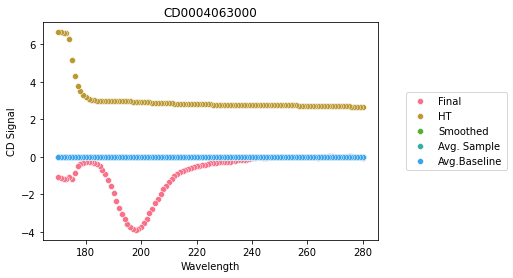

In [7]:
# Plot all six spectra for a few of ids

idx = dfOG.index[0], dfOG.index[200], dfOG.index[500]
spctypes = ['Final', 'HT', 'Smoothed', 'Avg. Sample', 'Avg.Baseline']

for i in idx:
    sns.set_palette('husl')
    data = dfOG.loc[i, 'CD']
    for t in spctypes:
        sns.scatterplot(x = data['Wavelength'], y = data[t])
    plt.ylabel('CD Signal')
    plt.legend(spctypes, loc = 'center right', bbox_to_anchor = (1.4,.5))
    plt.title(i)
    plt.show()

Not totally sure if the plots overlay or just if not all the spectra are available for all the IDs. Let's try the Smoothed and Final spectra and see how they compare, since these are likely to be the most processed/normalized/comparable.

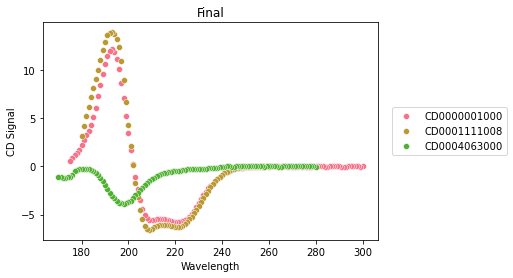

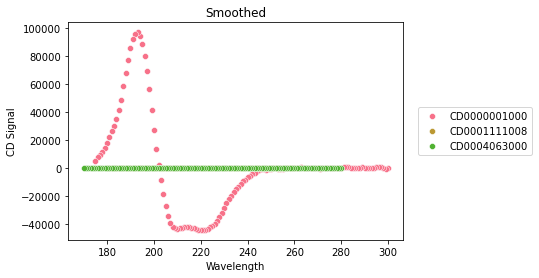

In [8]:
spctypes_analysis = ['Final', 'Smoothed']

for spectrum in spctypes_analysis:
    sns.set_palette('husl')
    for i in idx: 
        data = dfOG.loc[i, 'CD']
        sns.scatterplot(x = data['Wavelength'], y = data[spectrum])
    plt.ylabel('CD Signal')
    plt.legend(idx, loc = 'center right', bbox_to_anchor = (1.4,.5))
    plt.title(spectrum)
    plt.show()

It looks like we see more features in the "Final" spectra, while smoothed versions are either not available or basically a flat line for some of entries (although potentially could see more features if we zoom in). The y-axis units of the final suggest that it has likely been converted to mean residue ellipticity (mre), but let's confirm.

In [9]:
metadata_fields = dfOG.loc['CD0000001000', 'Info'].keys()
unit_fields = [f for f in metadata_fields if "units" in str.lower(f)]
print(unit_fields)

['Dichroism Units of Raw Sample Data', 'Dichroism Units of Raw Baseline Data', 'Dichroism Units of Average Sample Data', 'Dichroism Units of Averaged Baseline Data', 'Dichroism Units of Net Smoothed Data', 'Dichroism Units of Processed Data', 'Dichroism Units for CSA Standard']


In [10]:
# loop through dataframe to pull out unique values for each of the unit types
# presumably the "processed data" is the final
units_dict = {}
for field in unit_fields:
    units_dict[field] = set()

#entry = dfOG.Info[0]

for i in range(len(dfOG.Info)):
    print(i)
    try:
        entry = dfOG.Info[i]
        for field in unit_fields:
            units_dict[field].add(entry[field])
    except Exception: 
        traceback.print_exc()
        break
print(units_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
{'Dichroism Units of Raw Sample Data': {'Millidegrees', 'Daresbury Arbitrary Units', 'Millidegrees (theta)'}, 'Dichroism Units of Raw Baseline Data': {'Millidegrees', 'Daresbury Arbitrary Units', 'Millidegrees (theta)'}, 'Dichroism Units of Average Sample Data': {'Millidegrees', 'Daresbury Arbitrary Units', 'Millidegrees (theta)'}, 'Dichroism Units of Averaged Baseline Data': {'Millidegrees', 'Daresbury Arbitrary Units', 'Millidegrees (theta)'}, 'Dichroism Units of Net Smoothed Data': {'Millidegrees', 'Daresbury Arbitrary Units', 'Millidegrees (theta)'}, 'Dichroism Units of Processed Data': {'Delta Epsilon'}, 'Dichroism Units for CSA Standard': {'DRS units', 'Millidegrees (theta)', 'Mean Residue Ellipticity'}}


C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\4101844962.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry = dfOG.Info[i]
Traceback (most recent call last):
  File "C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\4101844962.py", line 14, in <module>
    units_dict[field].add(entry[field])
                          ~~~~~^^^^^^^
KeyError: 'Dichroism Units of Raw Sample Data'


In [11]:
dfOG.Info[72].keys()

C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\3659933405.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfOG.Info[72].keys()


dict_keys(['PCDDBID', 'FILE EXTRACTED', 'Protein Name', 'Alternative Protein Names', 'Source Organism', 'Protein Supplier', 'Zurich', 'E. coli', 'Wild-type', 'No data provided', '2011-08-24', 'Millidegrees (theta)', 'Delta Epsilon', 'SRCD', '6.26', 'Nanodrop', '10mM KH2PO4 pH 7.0; 0.05% CHM', '20', 'Daresbury 12.1', '0.0015', 'Interferometry', 'Cylindrical-Demountable', 'Suprasil', 'Nitrogen', '3', 'Stepped', '280', '173', 'HT value', '1', '2006-09-02', 'r18709', 'CSA', 'YES', '6.57', '0.10', '235-245', '1.97', '26.3', '25', '113573.6', '1049', '108.4', 'CDTool', '1.4', '7', '263-270', 'Crystal structure', '0.486', '0.021', '0.000', '0.186', '0.004', '0.086', '0.065', '0.151', '2gif', 'P31224', '-', '21505036', '1.20.1640.10 3.30.70.1430 3.30.70.1320 3.30.2090.10 1.10.3850.10', 'MPNFFIDRPI FAWVIAIIIM LAGGLAILKL PVAQYPTIAP PAVTISASYP GADAKTVQDT VTQVIEQNMN GIDNLMYMSS NSDSTGTVQI TLTFESGTDA DIAQVQVQNK LQLAMPLLPQ EVQQQGVSVE KSSSSFLMVV GVINTDGTMT QEDISDYVAA NMKDAISRTS GVGDVQLFGS QYAMRIWMNP N

This entry's info dictionary is totally messed up - the keys are not the right keys, many containing values instead of keys. (For example, the sequence right smack in the middle....) Let's see how much entries throw this type of error.

In [12]:
units_dict = {}

for field in unit_fields:
    units_dict[field] = set()

need_tlc = []

for i in range(len(dfOG.Info)):
    try:
        entry = dfOG.Info[i]
        for field in unit_fields:
            units_dict[field].add(entry[field])
    except: need_tlc.append(i)
        
print(units_dict)

{'Dichroism Units of Raw Sample Data': {'DRS units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'Daresbury Arbitrary Units', 'Mean Residue Ellipticity'}, 'Dichroism Units of Raw Baseline Data': {'Delta Epsilon', 'DRS units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'Daresbury Arbitrary Units', 'Mean Residue Ellipticity'}, 'Dichroism Units of Average Sample Data': {'Delta Epsilon', 'DRS units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'Daresbury Arbitrary Units'}, 'Dichroism Units of Averaged Baseline Data': {'DRS units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'Daresbury Arbitrary Units', 'Mean Residue Ellipticity'}, 'Dichroism Units of Net Smoothed Data': {'Delta Epsilon', 'DRS units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'Daresbury Arbitrary Units', 'Mean Residue Ellipticity'}, 'Dichroism Units of Processed Data': {'Delta Epsilon', 'Mean Residue Ellipticity'}, 'Dichroism Units for CSA St

C:\Users\dkoul\AppData\Local\Temp\ipykernel_55680\1839587112.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry = dfOG.Info[i]


In [13]:
need_tlc

[72, 74, 98, 121, 482, 508]

Relevant points learned from above: 
1. Entries with indices 72, 74, 98, 121, 482, and 508 seem to have issues in their Info blocks.
2. Units are all over the place, but processed data is the way to go. Here we have two options, so will need to figure out a way to address it.

   $\Delta$ $\epsilon$ = mre / 3298
   (Both $\Delta$ $\epsilon$ (Molar Circular Dichroism) and mre (Mean Residue Ellipticity) have been normalized for protein concentration, protein   size, and pathlength.)

## Make DataFrame to go into Algorithm

This dataframe should contain the following columns:
- the PCDDB ids (as index)
- amino acid sequence
- wavelengths *(select only 190 - 250, then we can disregard this in model and avoid complicating algorithms with experimental settings/buffer interactions/etc.?)*
- processed/final cd spectrum *(all converted to $\Delta$ $\epsilon$)*

For the first pass, won't worry about any of the other metadata components.

In [14]:
# PCDDB ID
ids_all = dfOG.index
tlc_ids = [ids_all[i] for i in need_tlc]
ids = [i for i in ids_all if i not in tlc_ids]

In [15]:
# Look at Wavelength breakdowns
wls = []

for id in ids:
    CD = dfOG.loc[id, 'CD']
    wl_used = CD['Wavelength']
    wls.append(wl_used)

print(wls[:3], wls[:-3])

[0      300.0
1      299.0
2      298.0
3      297.0
4      296.0
       ...  
121    179.0
122    178.0
123    177.0
124    176.0
125    175.0
Name: Wavelength, Length: 126, dtype: float64, 0      279.0
1      278.0
2      277.0
3      276.0
4      275.0
       ...  
100    179.0
101    178.0
102    177.0
103    176.0
104    175.0
Name: Wavelength, Length: 105, dtype: float64, 0      280.0
1      279.0
2      278.0
3      277.0
4      276.0
       ...  
101    179.0
102    178.0
103    177.0
104    176.0
105    175.0
Name: Wavelength, Length: 106, dtype: float64] [0      300.0
1      299.0
2      298.0
3      297.0
4      296.0
       ...  
121    179.0
122    178.0
123    177.0
124    176.0
125    175.0
Name: Wavelength, Length: 126, dtype: float64, 0      279.0
1      278.0
2      277.0
3      276.0
4      275.0
       ...  
100    179.0
101    178.0
102    177.0
103    176.0
104    175.0
Name: Wavelength, Length: 105, dtype: float64, 0      280.0
1      279.0
2      278.0
3      27

In [16]:
# Breakdown of how to access all the information

wl = range(190, 251)

def extract_data(id):
    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']
    CD = dfOG.loc[id, 'CD']
    if units == 'Delta Epsilon':
        spectrum = CD[CD['Wavelength'].isin(wl)]['Final']
    elif units == 'Mean Residue Ellipticity':
        spectrum = CD[CD['Wavelength'].isin(wl)]['Final']/3298
        
    seq = dfOG.loc[id, 'Info']['Sequence']
    
    return spectrum, seq

# lists to populate
seqs = [] # for amino acid sequences
delta_epsilon = [] # spectra for wavelengths 190 - 250
errors = [] # for anything that didn't work that I need to look at individually

for id in ids:
    try:           
        spectrum, seq = extract_data(id)
        delta_epsilon.append(spectrum.reset_index(drop = True))       
        seqs.append(seq)
    except:
        errors.append(id)

In [17]:
# Old version of the above
'''
# Breakdown of how to access all the information

wl = range(190, 251)

def extract_data(id):
    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']
    CD = dfOG.loc[id, 'CD']
    if units == 'Delta Epsilon':
        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']
    elif units == 'Mean Residue Ellipticity':
        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']/3298
        
    seq = dfOG.loc[id, 'Info']['Sequence']
    
    return spectrum, seq

# lists to populate
seqs = [] # for amino acid sequences
delta_epsilon = [] # spectra for wavelengths 190 - 250
errors = [] # for anything that didn't work that I need to look at individually

for id in ids:
    try:           
        spectrum, seq = extract_data(id)
        delta_epsilon.append(spectrum.reset_index(drop = True))       
        seqs.append(seq)
    except:
        errors.append(id)
'''

"\n# Breakdown of how to access all the information\n\nwl = range(190, 251)\n\ndef extract_data(id):\n    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']\n    CD = dfOG.loc[id, 'CD']\n    if units == 'Delta Epsilon':\n        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']\n    elif units == 'Mean Residue Ellipticity':\n        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']/3298\n        \n    seq = dfOG.loc[id, 'Info']['Sequence']\n    \n    return spectrum, seq\n\n# lists to populate\nseqs = [] # for amino acid sequences\ndelta_epsilon = [] # spectra for wavelengths 190 - 250\nerrors = [] # for anything that didn't work that I need to look at individually\n\nfor id in ids:\n    try:           \n        spectrum, seq = extract_data(id)\n        delta_epsilon.append(spectrum.reset_index(drop = True))       \n        seqs.append(seq)\n    except:\n        errors.append(id)\n"

In [18]:
print(errors)

['CD0000037000', 'CD0004000000', 'CD0005965000']


Now let's check that the shapes correspond and combine into a dataframe.

In [19]:
print(len(ids))
print(len(seqs))
print(len(delta_epsilon))

554
551
551


Hooray, those match! Will need to make a new ids list for the ones that don't need tlc (might leave those out of the EDA and finagle them later) and then combine everything into a dataframe.

In [20]:
ids_tlc = tlc_ids + errors
ids_notlc = [i for i in ids if i not in ids_tlc]

df1 = pd.DataFrame({'PCDDB ID': ids_notlc, 'Sequence': seqs, 'CD': delta_epsilon})

QC time! Let's look at the dataframe, then do a spot check to give me more confidence that data got extracted correctly from the original dataframe.

In [21]:
df1.head()

,PCDDB ID,Sequence,CD
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...


In [22]:
np.random.seed(90)
spotcheck_ids = np.random.choice(ids_notlc, size = 3)
print(spotcheck_ids)

['CD0003997002' 'CD0004006006' 'CD0004002012']


In [23]:
wl = range(190, 251)

for id in spotcheck_ids:
    new = df1[df1['PCDDB ID'] == id]
    old = dfOG.loc[id]
    
    

    print(f"ID: {id}")
    print(f"Sequence beginnings are {new['Sequence']} and {old['Info']['Sequence']}")
    print(f"New CD for 190 - 250 nm is {new['CD']}.")
    print(f"Old CD for 190 - 250 nm is {old['CD'][old['CD']['Wavelength'].between(190, 250)]['Final']}") # need to add between/subsetting to show old wavelengths 190 - 250

ID: CD0003997002
Sequence beginnings are 323    MGKGTASDKY EPAATSENAT KSKKKGKKDK IDKKRDLDEL KK...
Name: Sequence, dtype: object and MGKGTASDKY EPAATSENAT KSKKKGKKDK IDKKRDLDEL KKEVSMDDHK LSLDELHNKY GTDLTRGLTN ARAKEILARD GPNSLTPPPT TPEWIKFCRQ LFGGFSILLW IGAILCFLAY GIQAATEDEP ANDNLYLGVV LSTVVIVTGC FSYYQEAKSS RIMDSFKNMV PQQALVIRDG EKSTINAEFV VAGDLVEVKG GDRIPADLRI ISAHGCKVDN SSLTGESEPQ TRSPEFSSEN PLETRNIAFF STNCVEGTAR GVVVYTGDRT VMGRIATLAS GLEVGRTPIA IEIEHFIHII TGVAVFLGVS FFILSLILGY SWLEAVIFLI GIIVANVPEG LLATVTVCLT LTAKRMARKN CLVKNLEAVE TLGSTSTICS DKTGTLTQNR MTVAHMWFDN QIHEADTTEN QSGAAFDKTS ATWSALSRIA ALCNRAVFQA GQDNVPILKR SVAGDASESA LLKCIELCCG SVQGMRDRNP KIVEIPFNST NKYQLSIHEN EKSSESRYLL VMKGAPERIL DRCSTILLNG AEEPLKEDMK EAFQNAYLEL GGLGERVLGF CHFALPEDKY NEGYPFDADE PNFPTTDLCF VGLMAMIDPP RAAVPDAVGK CRSAGIKVIM VTGDHPITAK AIAKGVGIIS EGNETIEDIA ARLNIPIGQV NPRDAKACVV HGSDLKDLST EVLDDILHYH TEIVFARTSP QQKLIIVEGC QRQGAIVAVT GDGVNDSPAL KKADIGVAMG ISGSDVSKQA ADMILLDDNF ASIVTGVEEG RLIFDNLKKS IAYTLTSNIP

The extraction looks like it went well in that the values match between the two dataframes, but somehow all of the sequences are the same. Let's figure out where and why this happened!

In [24]:
for entry in ids_notlc[:5]:
    print(dfOG.loc[entry, 'Info']['Sequence'])
    print()

PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KRLQSIGTEN TEENRRFYRQ LLLTADDRVN PCIGGVILFH ETLYQKADDG RPFPQVIKSK GGVVGIKVDK GVVPLAGTNG ETTTQGLDGL SERCAQYKKD GADFAKWRCV LKIGEHTPSA LAIMENANVL ARYASICQQN GIVPIVEPEI LPDGDHDLKR CQYVTEKVLA AVYKALSDHH IYLEGTLLKP NMVTPGHACT QKYSHEEIAM ATVTALRRTV PPAVTGVTFL SGGQSEEEAS INLNAINKCP LLKPWALTFS YGRALQASAL KAWGGKKENL KAAQEEYVKR ALANSLACQG KYTPSGQAGA AASESLFISN HAY

RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KPAKNIILLI GDGMGDSEIT AARNYAEGAG GFFKGIDALP LTGQYTHYAL NKKTGKPDYV TDSAASATAW STGVKTYNGA LGVDIHEKDH PTILEMAKAA GLATGNVSTA ELQDATPAAL VAHVTSRKCY GPSATSEKCP GNALEKGGKG SITEQLLNAR ADVTLGGGAK TFAETATAGE WQGKTLREQA QARGYQLVSD AASLNSVTEA NQQKPLLGLF ADGNMPVRWL GPKATYHGNI DKPAVTCTPN PQRNDSVPTL AQMTDKAIEL LSKNEKGFFL QVEGASIDKQ DHAANPCGQI GETVDLDEAV QRALEFAKKE GNTLVIVTAD HAHASQIVAP DTKAPGLTQA LNTKDGAVMV MSYGNSEEDS QEHTGSQLRI AAYGPHAANV VGLTDQTDLF YTMKAALGLK

ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WIPPAYKGTS QADVGYGAYD LYDLGEFHQK GTVRTKYGTK GELQSAIKSL HSRD

Okay, so obviously these are not all the same... What are these sequences in the new dataframe that we made?

In [25]:
for entry in ids_notlc[:5]:
    print(df1[df1['PCDDB ID'] == entry]['Sequence'])
    print()

0    PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...
Name: Sequence, dtype: object

1    RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...
Name: Sequence, dtype: object

2    ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...
Name: Sequence, dtype: object

3    IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...
Name: Sequence, dtype: object

4    CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...
Name: Sequence, dtype: object



These all match what we would expect to find. So maybe we just got unlucky with the ids we generated? Let's check if the names will give us a clue, and then repeat the exercise with a different seed.

In [26]:
for entry in spotcheck_ids:
    print(dfOG.loc[entry, 'Info']['Protein Name'])

Sodium/potassium-transporting ATPase
Sodium/potassium-transporting ATPase
Sodium/potassium-transporting ATPase


In [27]:
np.random.seed(127)
spotcheck_ids2 = np.random.choice(ids_notlc, size = 3)

for id in spotcheck_ids2:
    new = df1[df1['PCDDB ID'] == id]
    old = dfOG.loc[id]
    
    

    print(f"ID: {id}")
    print(f"Sequence beginnings are {new['Sequence']} and {old['Info']['Sequence']}")
    print(f"New CD for 190 - 250 nm is {new['CD']}.")
    print(f"Old CD for 190 - 250 nm is {old['CD'][old['CD']['Wavelength'].between(190, 250)]['Final']}") # need to add between/subsetting to show old wavelengths 190 - 250

ID: CD0001208000
Sequence beginnings are 201    GSHGMQRMQA FIDRPGFGRF ITAVIMLNAV VLGMETSPYL ME...
Name: Sequence, dtype: object and GSHGMQRMQA FIDRPGFGRF ITAVIMLNAV VLGMETSPYL MERWGGLILA ADRICLGIFI VEIALKLTAQ RQRFFLNGWN LFDFVIVGIA LIPAAGGLSV LRALRILRVL RVISVAPRLR RVVEGFITAL PGMASVFLLM TIIFYIGAVI ATKLFAASFP DWFGDLGLSA YTLFQIMTLE SWSMGIVRPV MQVYPYAWLF FVPFIMITTF AVVNLLVGLI VNSMQDAHHA EDGERTDAYR DEVLARLEQI DQRLNALGET KK
New CD for 190 - 250 nm is 201    0     -0.073990
1     -0.071161
2     -0.09665...
Name: CD, dtype: object.
Old CD for 190 - 250 nm is 30    -0.073990
31    -0.071161
32    -0.096652
33    -0.107516
34    -0.149381
        ...    
86    11.305300
87    11.653700
88    11.698400
89    11.551200
90    11.131600
Name: Final, Length: 61, dtype: float64
ID: CD0000062000
Sequence beginnings are 60    VHQVLYRALV STKWLAESVR AGKVGPGLRV LDASWYSPGT RE...
Name: Sequence, dtype: object and VHQVLYRALV STKWLAESVR AGKVGPGLRV LDASWYSPGT REARKEYLER HVPGASFFDI EECRDKASPY EVMLPSEAGF ADYVGSLG

Okay, this is more like it! It does seem like we just happened to choose three instances of the same protein the first time around. At some point, it might be worth characterizing how many duplicates there are in the dataset, but for now will proceed with the dataset as is. In addition to checking duplicates, will need to come back in the future and incorporate the TLC samples.

Now, let's check out the CD spectra and if they are all the same size and, where they aren't, figure out what's going on.

In [28]:
df1['Spectrum Points'] = [len(x) for x in df1['CD']]
df1['Spectrum Points'].value_counts()

Spectrum Points
61    527
0      15
51      5
1       2
55      1
53      1
Name: count, dtype: int64

Since it's not that many, will just move forward with those spectra that have the full 61 points. May go back later to see if I can incorporate information from any of the others (e.g. those with 51 - 55 data points).

In [29]:
df3 = df1[df1['Spectrum Points'] == 61]
df3 = df3.drop('Spectrum Points', axis = 1)
df3.shape

(527, 3)

## Fitting the data

Now we will try to fit the data! Our Spectrum column is our dependent/response variable, and the Sequence column is our independent/explanatory variable.

Part of exploring ways to fit these data will include how to treat the amino acid sequence. Most modeling algorithms don't allow you to use a text string as an explanatory variable, so we will likely need to convert each sequence to a numerical vector or otherwise be creative with the feature engineering here.

#### AAIndex

https://www.genome.jp/aaindex/
Access via DBGET, explained here: https://www.genome.jp/en/about_dbget.html
Accessed here via Python package: https://pypi.org/project/aaindex/

Other resources potentially of use: 
- iFeature https://github.com/Superzchen/iFeature/
- biopython package

AAIndex has a LOT of potential amino acid indices that we could try. Seems very computationally challenging to try all of them (especially in combination), so we will start by choosing a few from different categories of physiochemical properties and see how much of a difference there between them and whether anything can be gained from combining them.

In [30]:
size = aaindex1['BIGC670101'].values # Residue volume (Bigelow, 1967)
partition_coeff = aaindex1['GARJ730101'].values # Partition coefficient (Garel et al., 1973)
hydrophobicity = aaindex1['ARGP820101'].values # Hydrophobicity index (Argos et al., 1982)
flexibility = aaindex1['BHAR880101'].values # Average flexibility indices (Bhaskaran-Ponnuswamy, 1988)
chemical_shifts = aaindex1['ANDN920101'].values # alpha-CH chemical shifts (Andersen et al., 1992)
K_helixcoil = aaindex1['FINA770101'].values #Helix-coil equilibrium constant (Finkelstein-Ptitsyn, 1977)
phi = aaindex1['LEVM760104'].values # Side chain torsion angle phi(AAAR) (Levitt, 1976)

In [31]:
properties = {'size': size, 'partition_coeff': partition_coeff, 'hydrophobicity': hydrophobicity, \
              'flexibility': flexibility, 'chemical_shifts': chemical_shifts, 'K_helixcoil': K_helixcoil, 'phi': phi}



In [32]:
def seq_vectorization(property, i):
    seq = df1['Sequence'][i]
    num_seq = pd.Series(map(property.get, list(seq)))
    return(num_seq.dropna())

In [33]:
vect_dict = {'size': [], 'partition_coeff': [], 'hydrophobicity': [], 'flexibility': [], \
             'chemical_shifts': [], 'K_helixcoil': [], 'phi': []}

for i in range(len(df1)):
    #print(i)
    for prop in properties:
        # print(prop)
        # print(vect_dict[prop
        # print(df1[prop][i])
        vect_dict[prop].append(seq_vectorization(properties[prop], i))

# At some point check that seq lengths are the same

In [34]:
df_props1 = pd.DataFrame(vect_dict)
df_props1.head()

,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [35]:
df2 = df1.join(df_props1)
df2.head()

,PCDDB ID,Sequence,CD,Spectrum Points,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,61,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,61,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,61,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,61,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,61,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [36]:
df2.dtypes

PCDDB ID           object
Sequence           object
CD                 object
Spectrum Points     int64
size               object
partition_coeff    object
hydrophobicity     object
flexibility        object
chemical_shifts    object
K_helixcoil        object
phi                object
dtype: object

### Predicting value at 222 nm

CD value at 222 nm is often used to track denaturation and is strongly correlated with helicity. Will add this as a column in case it is easier to predict just one value rather than the entire spectrum.

In [37]:
# Add column with value at 222 nm
idx_222 = list(wl).index(222)

df2['Spectrum Points'] = [len(x) for x in df2['CD']]
df4 = df2[df2['Spectrum Points'] == 61]
df4 = df4.drop('Spectrum Points', axis = 1)

print(df4.shape)

(527, 10)


In [38]:
df4.head()

,PCDDB ID,Sequence,CD,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [39]:
CD_222 = []

for index, row in df4.iterrows():
    CD_222.append(row['CD'][idx_222])

df4['CD_222nm'] = CD_222
df4.head()

,PCDDB ID,Sequence,CD,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi,CD_222nm
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...,-5.64417
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...,-3.51686
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...,-4.29644
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....,-1.43162
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...,-2.18352


During later processing, realized that the 'CD' column has some values that also seem to include wavelength info. Will correct column here.

In [56]:
# prepare output
CD_corr = np.zeros((len(df4['CD']), 61))
CD_222 = np.zeros(len(df4['CD_222nm']))

for idx, val in enumerate(df4['CD'].values):
    try:
        CD_corr[idx] = np.array(val).astype('float32')
    except ValueError:
        val = [s.split()[0] for s in val]
        CD_corr[idx] = np.array(val).astype('float32')
        
target_df_num = pd.DataFrame(CD_corr, columns = wl)

## Extract broad categorical features from spectra

Reference: Greenfield NJ "Using circular dichrosim spectra to estimate protein secondary structure" Nature Protocols 2006 (doi:10.1038/nprot.2006.202) <p>

While I will continue to try to get a functional Keras or other model, it seems unlikely that it will be able to extract meaningful information from so few spectra considering how complicated this problem is. In light of that, perhaps we can get some more reliable but still interesting insights from converting the spectral information into a subset categorical information about secondary structure that would be gleaned from the spectra. In particular: <p>

- $\alpha$-helices are expressed in negative bands at 222 nm and 208 nm and a positive band at 193 nm
- $\beta$-sheets (antiparallel) are expressed as negative bands 218 nm and positive band at 195 nm
- disordered proteins have very low ellipticity above 210 nm and negative bands near 195 nm

In [ ]:
wl_list = list(target_df_num.columns)
minima_at = []
for idx, data in target_df_num.iterrows():
    min_i, prop = find_peaks(-data)
    min_wl = [wl_list[i] for i in min_i]
    minima_at.append(min_wl)

As a first pass, we will say that the criteria will be:
- minimum between 217 - 219 => $\beta$
- minimum between 220 - 224 => $\alpha$
- negative value at 195 => random coil

In [83]:
alpha = np.zeros(len(target_df_num))
beta = np.zeros(len(target_df_num))

for idx, x in enumerate(minima_at):
    for y in x:
        if 217 <= y <=219:
            beta[idx] = True
        if 220 <= y <= 224:
            alpha[idx] = True

In [88]:
random_coil = [(x < 0) for x in target_df_num[195]]

In [96]:
target_df_cat = pd.DataFrame({'alpha': [bool(x) for x in alpha], 'beta': [bool(x) for x in beta], 'random_coil': random_coil})
target_df_cat.head(10)

,alpha,beta,random_coil
0,False,True,True
1,True,False,True
2,True,False,True
3,False,False,False
4,False,False,True
5,False,False,True
6,True,False,True
7,False,False,False
8,True,False,True
9,True,False,False


### Attempt #1: Input sequences, output spectrum from 190 - 250 nm


In [97]:
# import libraries (will move up to top section once I figure out what I'm doing)

from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [98]:
#Tokenize sequences (inputs)

sequences = df4['Sequence'].values

tokenizer = Tokenizer(char_level = True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)

# Accounting for different lengths of sequences with padding (here) and masking (in model build)
# for more info I liked: datascience.stackexchange.com question #48796
max_seq_length = max([len(seq) for seq in encoded_seqs]) - 1
padded_seqs = pad_sequences(encoded_seqs, maxlen = max_seq_length, padding = 'post')

In [99]:
#  Prepare input opbject
input_obj = Input(shape = (max_seq_length,))
input_dim = len(tokenizer.word_index) + 1

In [105]:
model = Sequential()
model.add(input_obj)
model.add(Embedding(input_dim, 10))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dense(500, activation = 'relu'))
model.add(Flatten())
model.add(Dense(61, activation = 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2383, 10)          230       
                                                                 
 lstm_4 (LSTM)               (None, 2383, 50)          12200     
                                                                 
 dense_5 (Dense)             (None, 2383, 500)         25500     
                                                                 
 flatten_1 (Flatten)         (None, 1191500)           0         
                                                                 
 dense_6 (Dense)             (None, 61)                72681561  
                                                                 
Total params: 72719491 (277.40 MB)
Trainable params: 72719491 (277.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, CD_corr)

In [112]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
13/13 [==============================] - 20s 1s/step - loss: -15152.2109 - accuracy: 0.0557
Epoch 2/20
13/13 [==============================] - 18s 1s/step - loss: -1074727.7500 - accuracy: 0.0506
Epoch 3/20
13/13 [==============================] - 18s 1s/step - loss: -9040891.0000 - accuracy: 0.0481
Epoch 4/20
13/13 [==============================] - 18s 1s/step - loss: -26761068.0000 - accuracy: 0.0633
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: -54024100.0000 - accuracy: 0.0481
Epoch 6/20
13/13 [==============================] - 18s 1s/step - loss: -94982344.0000 - accuracy: 0.0456
Epoch 7/20
13/13 [==============================] - 18s 1s/step - loss: -142087312.0000 - accuracy: 0.0506
Epoch 8/20
13/13 [==============================] - 18s 1s/step - loss: -199798192.0000 - accuracy: 0.0430
Epoch 9/20
13/13 [==============================] - 18s 1s/step - loss: -265240432.0000 - accuracy: 0.0506
Epoch 10/20
13/13 [=============================

As expected, the model that tries to fit the entire spectrum is not really able to do it (accuracy ~ 0.05). Now let's tweak the model slightly to give a single datum as output and use the wavelength at 222 nm as our y.

### Attempt #2: Sequence as input, signal at 222 nm as output

In [113]:
model2 = Sequential()
model2.add(input_obj)
model2.add(Embedding(input_dim, 10))
model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dense(500, activation = 'relu'))
model2.add(Flatten())
model2.add(Dense(1, activation = 'softmax'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 2383, 10)          230       
                                                                 
 lstm_5 (LSTM)               (None, 2383, 50)          12200     
                                                                 
 dense_7 (Dense)             (None, 2383, 500)         25500     
                                                                 
 flatten_2 (Flatten)         (None, 1191500)           0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1191501   
                                                                 
Total params: 1229431 (4.69 MB)
Trainable params: 1229431 (4.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
model2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [121]:
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, target_df_num[222])

In [122]:
model2.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
13/13 [==============================] - 14s 946ms/step - loss: 360.1852 - accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 12s 953ms/step - loss: 360.1852 - accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 12s 958ms/step - loss: 360.1852 - accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 13s 965ms/step - loss: 360.1852 - accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 13s 977ms/step - loss: 360.1852 - accuracy: 0.0000e+00


NOt entirely sure what's happening there and why the accuracy goes down as we make decrease dimentionality of our output. However, either way this doesn't seem likely to be a useful approach without lots more data.

What if we compile the model above with binary cross-entropy as the loss function and look at alpha, beta, or random_coil?

In [117]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, target_df_cat['alpha'])
model2.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
13/13 [==============================] - 15s 971ms/step - loss: 4730774.0000 - accuracy: 0.6152
Epoch 2/6
13/13 [==============================] - 13s 979ms/step - loss: 4396974.0000 - accuracy: 0.6152
Epoch 3/6
13/13 [==============================] - 13s 976ms/step - loss: 4056626.5000 - accuracy: 0.6152
Epoch 4/6
13/13 [==============================] - 13s 976ms/step - loss: 2678401.2500 - accuracy: 0.6152
Epoch 5/6
13/13 [==============================] - 12s 950ms/step - loss: 603270.9375 - accuracy: 0.6152
Epoch 6/6
13/13 [==============================] - 12s 950ms/step - loss: 69770.2891 - accuracy: 0.6152


Much closer to a real model with some predictive power, at least based on accuracy. The loss seems to be stupid high, although I'm not sure what implications this has as compared to accuracy for the predictive value. What does this look like for the other two booleans?

In [123]:
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, target_df_cat['beta'])
model2.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
13/13 [==============================] - 14s 971ms/step - loss: 0.6127 - accuracy: 0.3873
Epoch 2/6
13/13 [==============================] - 13s 963ms/step - loss: 0.6127 - accuracy: 0.3873
Epoch 3/6
13/13 [==============================] - 12s 956ms/step - loss: 0.6127 - accuracy: 0.3873
Epoch 4/6
13/13 [==============================] - 12s 952ms/step - loss: 0.6127 - accuracy: 0.3873
Epoch 5/6
13/13 [==============================] - 13s 961ms/step - loss: 0.6127 - accuracy: 0.3873
Epoch 6/6
13/13 [==============================] - 13s 985ms/step - loss: 0.6127 - accuracy: 0.3873


Meaningful but much lower accuracy for $\beta$ sheets - makes sense scientifically since that signal is relatively subtle compared to $\alpha$ helices. Loss is much lower here, presumably because signal is much lower as well, although I'm not sure it should be enough to result in SUCH a dramatic difference.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, target_df_cat['random_coil'])
model2.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
13/13 [==============================] - 12s 962ms/step - loss: 0.0557 - accuracy: 0.9443
Epoch 2/6
13/13 [==============================] - 12s 952ms/step - loss: 0.0557 - accuracy: 0.9443
Epoch 3/6
13/13 [==============================] - 12s 956ms/step - loss: 0.0557 - accuracy: 0.9443
Epoch 4/6
13/13 [==============================] - 12s 946ms/step - loss: 0.0557 - accuracy: 0.9443
Epoch 5/6
13/13 [==============================] - 12s 951ms/step - loss: 0.0557 - accuracy: 0.9443
Epoch 6/6
13/13 [==============================] - 15s 1s/step - loss: 0.0557 - accuracy: 0.9443


Now that is a model! Disorder is apparently much easier to predict from sequence alone than individual secondary structural elements! How does this do on the test set?

In [125]:
y_pred = model2.predict(X_test)

5/5 [==============================] - 2s 239ms/step


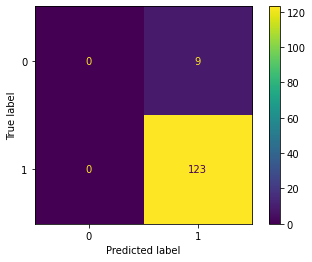

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

Well, that explains why model metrics were good for this one... Let's see if we can set up a model to use all three of the boolean columns.

### Attempt #3: Sequence as input, all three of the boolean variables as output.

In [130]:
model3 = Sequential()
model3.add(input_obj)
model3.add(Embedding(input_dim, 10))
model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dense(500, activation = 'relu'))
model3.add(Flatten())
model3.add(Dense(3, activation = 'softmax'))
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 2383, 10)          230       
                                                                 
 lstm_6 (LSTM)               (None, 2383, 50)          12200     
                                                                 
 dense_9 (Dense)             (None, 2383, 500)         25500     
                                                                 
 flatten_3 (Flatten)         (None, 1191500)           0         
                                                                 
 dense_10 (Dense)            (None, 3)                 3574503   
                                                                 
Total params: 3612433 (13.78 MB)
Trainable params: 3612433 (13.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, target_df_cat)
model3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=6, batch_size=32)

Epoch 1/6
13/13 [==============================] - 16s 1s/step - loss: 0.4423 - accuracy: 0.1114 - val_loss: 0.4298 - val_accuracy: 0.0985
Epoch 2/6
13/13 [==============================] - 14s 1s/step - loss: 0.4193 - accuracy: 0.1139 - val_loss: 0.4663 - val_accuracy: 0.0985
Epoch 3/6
13/13 [==============================] - 13s 1s/step - loss: 0.4061 - accuracy: 0.1114 - val_loss: 0.4304 - val_accuracy: 0.1061
Epoch 4/6
13/13 [==============================] - 13s 1s/step - loss: 0.3871 - accuracy: 0.1241 - val_loss: 0.4423 - val_accuracy: 0.1136
Epoch 5/6
13/13 [==============================] - 14s 1s/step - loss: 0.3789 - accuracy: 0.1190 - val_loss: 0.4364 - val_accuracy: 0.1288
Epoch 6/6
13/13 [==============================] - 14s 1s/step - loss: 0.3685 - accuracy: 0.1367 - val_loss: 0.4552 - val_accuracy: 0.1212


Doesn't seem like we're getting very far with this models... Let's try using the aaindex and see if there is a simpler predictor we can use with some data tweaking.

### Attempt #4: More pre-processing/feature engineering, less complicated modeling.

In [151]:
df5 = df4[properties.keys()]

means = {}

for p in properties.keys():
    means[p] = np.zeros(len(df5))
    for idx, data in enumerate(df5[p]):
        means[p][idx] = np.mean(data)

X_means = pd.DataFrame(means)
X_means.head()

,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,80.162259,0.476749,0.863085,0.441884,4.332590,0.965565,225.273554
1,76.985778,0.441511,0.760800,0.442784,4.341756,0.946844,227.688000
2,83.189648,0.658799,0.882609,0.440843,4.380807,0.954141,223.668116
3,78.535135,0.434324,0.912703,0.438757,4.390270,0.922973,223.585135
4,77.307054,0.592158,0.817220,0.438510,4.342033,0.923029,226.922822


In [152]:
sums = {}

for p in properties.keys():
    sums[p] = np.zeros(len(df5))
    for idx, data in enumerate(df5[p]):
        sums[p][idx] = np.sum(data)

X_sum = pd.DataFrame(sums)
X_sum.head()

,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,29098.9,173.06,313.30,160.404,1572.73,350.50,81774.3
1,34643.6,198.68,342.36,199.253,1953.79,426.08,102459.6
2,40180.6,318.20,426.30,212.927,2115.93,460.85,108031.7
3,5811.6,32.14,67.54,32.468,324.88,68.30,16545.3
4,18631.0,142.71,196.95,105.681,1046.43,222.45,54688.4


In [155]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_means, target_df_num[222], random_state = 77)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sum, target_df_num[222], random_state = 98)

### Linear Regression

In [164]:
from sklearn.linear_model import LinearRegression

In [190]:
# Means
ytm_reshaped = y_train_m.values.reshape(-1, 1)

for col in X_train_m:
    X = X_train_m[col].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, ytm_reshaped)
    print("Training score for ", col, ":", reg.score(X, ytm_reshaped))

Training score for  size : 0.0023772591137547483
Training score for  partition_coeff : 0.0002041197918266624
Training score for  hydrophobicity : 0.0003112803514416784
Training score for  flexibility : 0.0027994947097983447
Training score for  chemical_shifts : 0.0017268613212189088
Training score for  K_helixcoil : 0.0019400582159938562
Training score for  phi : 0.0021202439034468945


In [191]:
# Sums
yts_reshaped = y_train_s.values.reshape(-1, 1)

for col in X_train_s:
    X = X_train_s[col].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, yts_reshaped)
    print("Training score for ", col, ":", reg.score(X, yts_reshaped))

Training score for  size : 0.016783627328839645
Training score for  partition_coeff : 0.018038192617561122
Training score for  hydrophobicity : 0.01742517093368534
Training score for  flexibility : 0.017232920267875262
Training score for  chemical_shifts : 0.017104244459155038
Training score for  K_helixcoil : 0.016920746585478152
Training score for  phi : 0.017278972030573603


In [194]:
import sklearn.ensemble as ske
import sklearn.linear_model as sklin

In [199]:
targets = target_df_cat.join(target_df_num[222])
means_sums = X_means.join(X_sum, lsuffix = "_mean", rsuffix = "sum")

In [195]:
models = [ske.RandomForestClassifier(), ske.AdaBoostClassifier(), ske.RandomForestRegressor(), sklin.LogisticRegression()]

In [222]:
X_train, X_test, y_train, y_test = train_test_split(means_sums, target_df_cat, random_state = 999)

for model in models:
    for col in y_train:
        y = y_train[col].values
        model.fit(X_train, y)
        print("Training score for model", model, "and target", col, "is", model.score(X_train, y))
        print("Validation score for model", model, "and target", col, "is", model.score(X_test, y_test[col].values))

Training score for model RandomForestClassifier() and target alpha is 0.8481012658227848
Validation score for model RandomForestClassifier() and target alpha is 0.7727272727272727
Training score for model RandomForestClassifier() and target beta is 0.7367088607594937
Validation score for model RandomForestClassifier() and target beta is 0.6818181818181818
Training score for model RandomForestClassifier() and target random_coil is 0.9898734177215189
Validation score for model RandomForestClassifier() and target random_coil is 0.9545454545454546
Training score for model AdaBoostClassifier() and target alpha is 0.8379746835443038
Validation score for model AdaBoostClassifier() and target alpha is 0.7878787878787878
Training score for model AdaBoostClassifier() and target beta is 0.7341772151898734
Validation score for model AdaBoostClassifier() and target beta is 0.6515151515151515
Training score for model AdaBoostClassifier() and target random_coil is 0.9898734177215189
Validation score 

C:\Users\dkoul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [212]:
X_train, X_test, y_train, y_test = train_test_split(means_sums, target_df_num, random_state = 99)

rfr_scores_train = []
rfr_scores_test = []

for col in y_train:
    y = y_train[col].values
    model = ske.RandomForestRegressor()
    model.fit(X_train, y)
    rfr_scores_train.append(model.score(X_train, y))
    rfr_scores_test.append(model.score(X_test, y_test[col].values)) # does not seem to be give me values that you would expect to get for R2

C:\Users\dkoul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dkoul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


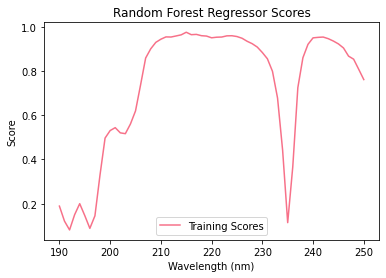

In [218]:
sns.lineplot(x = target_df_num.columns, y = rfr_scores_train, label = 'Training Scores')
# sns.lineplot(x = target_df_num.columns, y = rfr_scores_test, label = 'Validation Scores')
plt.title('Random Forest Regressor Scores')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Score')
plt.show()

In [220]:
y = y_train[222].values
y_true = y_test[222].values

rfr = ske.RandomForestRegressor()
rfr.fit(X_train, y)
print("Training score:", rfr.score(X_train, y))
print("Validation score:", rfr.score(X_test, y_true))
print(rfr.feature_importances_)

Training score: 0.950488083389648
Validation score: -25.453114608058716
[7.13077391e-03 8.47037265e-01 2.07227122e-03 1.25633905e-01
 7.89059672e-03 2.59275644e-03 1.62534720e-03 4.16181845e-04
 3.42295830e-04 5.97835595e-04 2.53917006e-04 3.02907798e-03
 6.13293993e-04 7.64482768e-04]


Apparently R<sup>2</sup> for a RandomForestRegressor can be negative because (from the docs) "the model can be arbitrarily worse." So it seems like overall looking at the boolean values with a Random Forest Classifier or the Ada Boost Classifier is potentially promising.

### SVM

In [223]:
from sklearn import svm

In [225]:
svms = [svm.SVC(), svm.NuSVC(), svm.LinearSVC()]

X_train, X_test, y_train, y_test = train_test_split(means_sums, target_df_cat, random_state = 999)

for model in svms:
    for col in y_train:
        y = y_train[col].values
        model.fit(X_train, y)
        print("Training score for model", model, "and target", col, "is", model.score(X_train, y))
        print("Validation score for model", model, "and target", col, "is", model.score(X_test, y_test[col].values))

Training score for model SVC() and target alpha is 0.7012658227848101
Validation score for model SVC() and target alpha is 0.7045454545454546
Training score for model SVC() and target beta is 0.6151898734177215
Validation score for model SVC() and target beta is 0.5757575757575758
Training score for model SVC() and target random_coil is 0.9367088607594937
Validation score for model SVC() and target random_coil is 0.9545454545454546
Training score for model NuSVC() and target alpha is 0.7063291139240506
Validation score for model NuSVC() and target alpha is 0.7272727272727273
Training score for model NuSVC() and target beta is 0.6430379746835443
Validation score for model NuSVC() and target beta is 0.6212121212121212


ValueError: specified nu is infeasible

In [231]:
X_train, X_test, y_train, y_test = train_test_split(means_sums, target_df_num, random_state = 3000)

svr = svm.SVR()
svr.fit(X_train, y_train[222].values)

print("Training score for SVR is", svr.score(X_train, y_train[222].values))
print("Validation score for SVR is", svr.score(X_test, y_test[222].values))

Training score for SVR is 0.006171815888161736
Validation score for SVR is 0.004101219598509065


In [232]:
for col in target_df_cat:
    print(target_df_cat[col].value_counts())

alpha
True     331
False    196
Name: count, dtype: int64
beta
False    319
True     208
Name: count, dtype: int64
random_coil
True     496
False     31
Name: count, dtype: int64


## Conclusions

We seemed to see promising results with three models:
- RandomForestClassifier
- AdaBoostClassifier
- SVC (Support Vector Classification)

The classifiers alone showed promise - even 222 nm did not have predictive power as a continuous variable. Important to note that while random_coil is quite unbalanced in its classes, the others show a ~2:3 ratio, which suggests those results aren't artifically good by just ignoring some potential outcomes. Will try to identify which features actually make a difference during the next section (feature engineering).